## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import matplotlib.pyplot as plt
import numpy as np

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
#if not os.path.exists('sonnets.txt'):
#    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt
#
#with open('sonnets.txt', 'r') as iofile:
#    text = iofile.readlines()
    
#TEXT_START = 45
#TEXT_END = -368
#text = text[TEXT_START : TEXT_END]
#assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

#assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
#assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
#print('OK!')

### Data loading: "Евгений Онегин"


In [4]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2022-12-26 05:20:12--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2022-12-26 05:20:12 (7.84 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
# Join all the strings into one and lowercase it

text = ''.join(text).lower()

In [8]:
poems = text.split('\n\n\n')
poems.pop(poems.index('\nглава седьмая'))
poems.pop(poems.index('\nглава шестая'))
poems.pop(poems.index('\nглава восьмая'))
poems.pop(poems.index('\nглава четвертая'))

for idx, poem in enumerate(poems):
  poems[idx] = poem[poem.index('\n\n')+2:]

Put all the characters, that you've seen in the text, into variable `tokens`.

In [10]:
tokens = sorted(set(text))
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [12]:
# dict <index>:<char>
token_to_idx = {tokens[i]: i for i in range(len(tokens))}
# dict <char>:<index>
idx_to_token = {i: tokens[i] for i in range(len(tokens))}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

max length = 2081


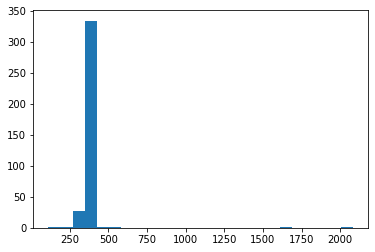

In [13]:
MAX_LENGTH = max(map(len, poems))
start_token = "\n\n"
end_token = "\n\n\n"
print("max length =", MAX_LENGTH)

plt.hist(list(map(len, poems)), bins=25);

In [14]:
def to_matrix(names, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    max_len = (max_len or max(map(len, names))) + 1
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_idx[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [15]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [16]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        self.x_emb = x_emb

        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)
        self.x_and_h = x_and_h
        
        h_next = torch.tanh(h_next)
        self.h_next = h_next
        
        assert h_next.size() == h_prev.size()

        logits = self.rnn_to_logits(h_next)
        self.logits = logits
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [17]:
def rnn_loop(char_rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [18]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters(), lr=0.001)
opt.zero_grad()
history = []

In [23]:
from tqdm.autonotebook import tqdm

for i in tqdm(range(1000)):
    batch_ix = to_matrix(sample(poems, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(
      predictions_logp.contiguous().view(-1, len(tokens)),
      actual_next_tokens.contiguous().view(-1)
    )

    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

  0%|          | 0/1000 [00:00<?, ?it/s]

Plot the loss function (axis X: number of epochs, axis Y: loss function).

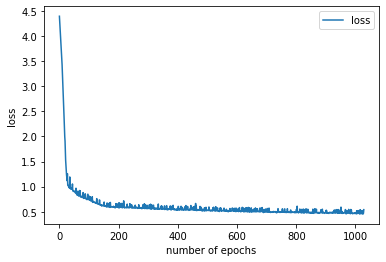

In [24]:
plt.plot(history,label='loss')
plt.legend()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.show()

In [36]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]

        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [26]:
for i in [0.1,0.2,0.5,0.7,1.0]:
  print("temperature = ",i, ', text: ', generate_sample(char_rnn, seed_phrase='п', temperature=i), '\n')

temperature =  0.1 , text:  пой                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [27]:
class LSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64, dropout = 0.7):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(
            input_size = emb_size,
            hidden_size = rnn_num_units,
            batch_first = True,
            num_layers = 2,
            dropout = dropout)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden=None):
        assert isinstance(x.data, torch.LongTensor)
        if hidden:
            h, c = hidden
            h_seq, (h, c) = self.rnn(self.emb(x), (h, c))
        else :
            h_seq, (h, c) = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, (h, c)
    
model_lstm = LSTMLoop()
opt = torch.optim.Adam(model_lstm.parameters())
history = []

In [30]:
for i in tqdm(range(2000)):
    batch_ix = to_matrix(sample(poems, 16), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    hidden_state = torch.randn(2, 16, 64)
    logp_seq, _ = model_lstm(batch_ix)
    
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

  0%|          | 0/2000 [00:00<?, ?it/s]

In [31]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    hidden_state = None
    
    if len(seed_phrase) > 1:
        _, hidden_state = char_rnn(x_sequence[:, :-1])
    
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hidden_state = char_rnn(x_sequence[:, -1].view(1, 1), hidden_state)
        logp_next = logp_next[:, -1]
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [32]:
for i in [0.1, 0.2, 0.5, 1.0, 2.0]:
  print("temperature = ",i, ', text: ', generate_sample(model_lstm, seed_phrase='п', temperature=i), '\n')

temperature =  0.1 , text:  повел на в вола на ссерой сол полен олонь полоть,
о но в сот воста то не на не востоль
полеле на на но на стать и серон сосной порет
не в села на на серь на полень ворени столь
седе сталь в остать о на на не на несть,
постоли в вола но на в сет полать
 сена остоне стороль
и просто на стот ом с пона от олесь
он вота стола столи столье,
поре стеле но на порорень олай столь сеть пороль
ол ва пола не на то сель полат о постоль,
и онот в не но не но на но стола сеть
пора но пода поро полот полонь поротне соль
ол на порорань в олодной сорный
стал в сторе в сорол сет пороть
и повол ворель и стеть полеть,
се паста по породел оснол он ностий сель воло,
в на с остороне посталь в поронь и сторь серь
порель она поролий сель и торь
полет в соте стате с на пороль
пола но с воре столь  селот и но стель серей,
поста на порели серень,
в он поро на стала на стоть воронь порет ола
сто порель и постоль
оро столе пороне столь парорь
и поролот сота порани,
сет пола  сорол остелон

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [33]:
# Saving and loading code here
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/'

Mounted at /content/gdrive


In [38]:
torch.save(char_rnn, f"{path}/char_rnn.pth")
model_loaded = torch.load(f"{path}/char_rnn.pth")
generate_sample(model_loaded, seed_phrase='п', temperature=0.2)

'пой бони на ве стоной и то поной се стот во стой сто                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [35]:
torch.save(model_lstm, f"{path}/char_lstm_onegin.pth")
model_loaded = torch.load(f"{path}/char_lstm_onegin.pth")
print(generate_sample(model_loaded, seed_phrase=' ', temperature=0.5))

 ха ви нем нов бирени бовом зочь,
слор водули к сидань ку стень на нан серин вводой моль
пелон пагоснай и но не и на бул иститола та понь омил.
 опсака прирон оскоды им
ол с втодость пабосесть,
песхе пол в веди секи дсруз на ность поль,
скат на сно зра сна сродот,
и стетот у пема на ланит,
поленья на богат ори
промем тет да постем
и на на стежелно нало озель сидлоли сесь пеленом,
и зрадольны ни на несны, сруга,
прочобет тора чостень волел,
во тормай ота неки снелово срнеги.
и но в порек на споролой и ж вот ози парань и восто,
полерит стотень,
и саном прорыч бать свочь в дажтой и  том момит подольни,
о нес зрома мрасты сдесь,
мло дега ного пре торовот,
перен модала то нот пасль,
сне сана в пророе негони не нро верени,
остлеподон поболи сене и сваль долана,
снеста и мам в овни стола ни тод пода,,
и
срола гром на зодвотут и воне на пироголь.
и ногко уто равний нит па сларне,
ое посколу пинен в насна чера
вана поламы додонь,
пресо дел зосен батмекил и натной там,
ге сна порила ет
но ит им 

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)